This notebook aims to create a plot showing the effect of each transformation method on expressivity and accuracy

## Dataset

In [8]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator

OGB_dataset = PygGraphPropPredDataset(
    name='ogbg-molhiv', root='./dataset/OGB')

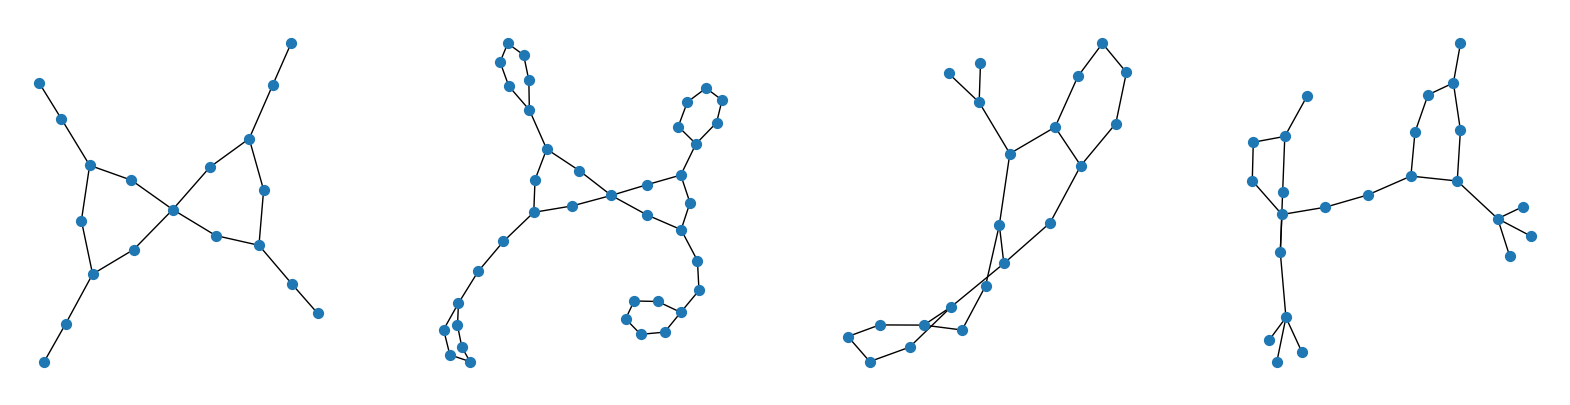

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

plt.figure(figsize=(20,5))

for i, data in enumerate(OGB_dataset[0:4], 1):
    plt.subplot(1, 4, i)
    G = to_networkx(data, to_undirected = True)
    nx.draw(G, pos=nx.spring_layout(G), node_size=50)

plt.show()

# Transformations

In [6]:
import torch
import copy
import networkx as nx
import random
import numpy as np
from torch_geometric.transforms import VirtualNode, AddLaplacianEigenvectorPE
from torch_geometric.utils import from_networkx, to_networkx, to_undirected, to_dense_adj, degree
from torch_geometric.data import InMemoryDataset
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomDataset(InMemoryDataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data, self.slices = self.collate(data_list)
        

###Visual Node
def apply_vn(pyg_dataset):
    vn_dataset = copy.deepcopy(pyg_dataset)  # Make a deep copy to preserve the original dataset
    transform = VirtualNode()

    # Create a list to store transformed graphs
    transformed_data_list = []

    for data in vn_dataset:
        transformed_data_list.append(transform(data))

    vn_dataset = CustomDataset(transformed_data_list)

    return vn_dataset

###Centrality
def add_centrality_to_node_features(data, centrality_measure='degree'):
    G = to_networkx(data, node_attrs=['x'], to_undirected=True)

    # Compute the centrality measure
    if centrality_measure == 'degree':
        centrality = nx.degree_centrality(G)
    elif centrality_measure == 'closeness':
        centrality = nx.closeness_centrality(G)
    elif centrality_measure == 'betweenness':
        centrality = nx.betweenness_centrality(G)
    elif centrality_measure == 'eigenvector':
        if not nx.is_connected(G):
        # Handle connected components separately
            centrality = {}
            for component in nx.connected_components(G):
                subgraph = G.subgraph(component)
                sub_centrality = nx.eigenvector_centrality(subgraph, max_iter=500, tol=1e-4)
                centrality.update(sub_centrality)
        else:
            centrality = nx.eigenvector_centrality(G, max_iter=500, tol=1e-4)
    else:
        raise ValueError(f'Unknown centrality measure: {centrality_measure}')
    
    # Convert centrality to tensor and add as node feature
    centrality_values = list(centrality.values())
    centrality_tensor = torch.tensor(centrality_values, dtype=torch.float).view(-1, 1)
    centrality_tensor = (centrality_tensor - centrality_tensor.mean()) / (centrality_tensor.std() + 1e-8)
    data.x = torch.cat([data.x, centrality_tensor], dim=-1)

    return data

def centrality(dataset, centrality_measure='degree'):
    original_dataset = copy.deepcopy(dataset)
    addCentrality_list = []
    for data in original_dataset:
        if centrality_measure == 'degree':
            data = add_centrality_to_node_features(data, centrality_measure='degree')
            addCentrality_list.append(data)
        elif centrality_measure == 'closeness':
            data = add_centrality_to_node_features(data, centrality_measure='closeness')
            addCentrality_list.append(data)
        elif centrality_measure == 'betweenness':
            data = add_centrality_to_node_features(data, centrality_measure='betweenness')
            addCentrality_list.append(data)
        elif centrality_measure == 'eigenvector':
            data = add_centrality_to_node_features(data, centrality_measure='eigenvector')
            addCentrality_list.append(data)
        else:
            raise ValueError(f'Unknown centrality measure: {centrality_measure}')
        
    addCentrality_dataset = CustomDataset(addCentrality_list)

    return addCentrality_dataset

###Distance Encoding
def distance_encoding_node_augmentation(data):
    G = to_networkx(data, node_attrs=['x'], to_undirected = True)
    num_nodes = data.num_nodes

    # Initialize the distance matrix with infinity
    distance_matrix = [[float('inf')] * num_nodes for _ in range(num_nodes)]
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    
    # Populate the distance matrix with actual shortest path lengths
    for i in range(num_nodes):
        distance_matrix[i][i] = 0  # Distance to self is 0
        if i in shortest_paths:
            for j, d in shortest_paths[i].items():
                distance_matrix[i][j] = d

    # Convert the distance matrix to a tensor
    distance_tensor = torch.tensor(distance_matrix, dtype=torch.float)
    
    # Example: Add average distance to node features
    finite_distances = torch.where(distance_tensor == float('inf'), torch.tensor(float('nan')), distance_tensor)
    average_distance = torch.nanmean(finite_distances, dim=1).view(-1, 1)  # Use nanmean to ignore infinities
    data.x = torch.cat([data.x, average_distance], dim=1)
    
    return data

def distance_encoding_edge_rewiring(data):
    """
    Add edges between all pairs of nodes with shortest path distance as a new edge attribute,
    while preserving original edge attributes.
    """
    G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)
    G_transformed = G.copy()

    connected_components = list(nx.connected_components(G))
    shortest_paths = {}

    # Compute shortest paths for each connected component
    for component in connected_components:
        subgraph = G.subgraph(component)
        component_paths = dict(nx.all_pairs_shortest_path_length(subgraph))
        shortest_paths.update(component_paths)

    num_edge_attrs = data.edge_attr.shape[1] if data.edge_attr is not None else 0

    nodes = list(G.nodes)
    for i in nodes:
        for j in nodes:
            if i != j:
                if G.has_edge(i, j):
                    original_attr = G[i][j].get('edge_attr', [])
                    if not isinstance(original_attr, list):
                        original_attr = [original_attr]
                    G_transformed[i][j]['edge_attr'] = original_attr + [1]
                else:
                    if j in shortest_paths[i]:
                        distance = shortest_paths[i][j]
                    else:
                        distance = 1e9  # Replace inf with a large finite value
                    new_attr = [0] * num_edge_attrs + [distance]
                    G_transformed.add_edge(i, j, edge_attr=new_attr)

    new_data = from_networkx(G_transformed, group_node_attrs=['x'], group_edge_attrs=['edge_attr'])
    new_data.edge_attr = torch.tensor(new_data.edge_attr, dtype=torch.float)

    # Check for invalid values
    if torch.isnan(new_data.edge_attr).any() or torch.isinf(new_data.edge_attr).any():
        raise ValueError("Edge attributes contain invalid values!")

    new_data.y = data.y
    return new_data

def distance_encoding(dataset, method = 'node_augmentation'):
    original_dataset = copy.deepcopy(dataset)
    distance_encoding_list = []
    for data in original_dataset:
        if method == 'node_augmentation':
            data = distance_encoding_node_augmentation(data)
            distance_encoding_list.append(data)
        elif method == 'edge_rewiring':
            data = distance_encoding_edge_rewiring(data)
            distance_encoding_list.append(data)
        else:
            raise ValueError(f'Unknown distance encoding method: {method}')
    distance_encoding_dataset = CustomDataset(distance_encoding_list)
    return distance_encoding_dataset

###Subgraph Extraction
def extract_local_subgraph_features(data, radius=2):
    # Convert PyG data to NetworkX graph
    G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)

    # Initialize a list to store subgraph features for each node
    subgraph_sizes = []
    subgraph_degrees = []
    
    for node in G.nodes():
        # Extract the ego graph (subgraph) around the node
        subgraph = nx.ego_graph(G, node, radius=radius)
        
        # Example feature 1: Size of the subgraph (number of nodes)
        subgraph_size = subgraph.number_of_nodes()
        subgraph_sizes.append(subgraph_size)
        
        # Example feature 2: Average degree of the subgraph
        subgraph_degree = np.mean([d for n, d in subgraph.degree()])
        subgraph_degrees.append(subgraph_degree)
        
    # Convert the features to tensors and add them as node features
    subgraph_sizes_tensor = torch.tensor(subgraph_sizes, dtype=torch.float).view(-1, 1)
    subgraph_degrees_tensor = torch.tensor(subgraph_degrees, dtype=torch.float).view(-1, 1)
    
    # Concatenate the new features to the existing node features
    data.x = torch.cat([data.x, subgraph_sizes_tensor, subgraph_degrees_tensor], dim=-1)
    
    return data

def subgraph_extraction(dataset, radius=2):
    original_dataset = copy.deepcopy(dataset)
    subgraph_extraction_list = []
    for data in original_dataset:
        data = extract_local_subgraph_features(data, radius=radius)
        subgraph_extraction_list.append(data)
    subgraph_extraction_dataset = CustomDataset(subgraph_extraction_list)
    return subgraph_extraction_dataset

def canonicalize_eigenvectors(eigenvectors):
    """
    Canonicalize eigenvectors by fixing their signs for consistency.
    This ensures that isomorphic graphs will have the same eigenvectors.
    """
    for i in range(eigenvectors.shape[1]):
        if eigenvectors[0, i] < 0:  # Flip sign if the first element is negative
            eigenvectors[:, i] = -eigenvectors[:, i]
    return eigenvectors

def add_canonicalized_laplacian_pe_pyg(data, k=5, max_features=12):
    """
    Add canonicalized Laplacian positional encoding to a PyG data object.

    Args:
        data (torch_geometric.data.Data): PyG data object.
        k (int): Number of Laplacian eigenvectors to compute.
        max_features (int): Total desired node feature dimensions after encoding.

    Returns:
        data (torch_geometric.data.Data): PyG data object with Laplacian PE appended to node features.
    """
    # Step 1: Convert PyG graph to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Step 2: Compute sparse adjacency matrix
    adj = nx.to_scipy_sparse_array(G, format='csr').astype(np.float64)

    # Step 3: Compute normalized Laplacian matrix
    laplacian = csgraph.laplacian(adj, normed=True)

    # Step 4: Handle small graphs
    num_nodes = adj.shape[0]
    if num_nodes <= 1:
        raise ValueError(f"Graph has too few nodes ({num_nodes}) for Laplacian PE.")
    num_eigenvectors = min(k, num_nodes - 1)  # Ensure k < num_nodes

    # Step 5: Compute the smallest eigenvectors using sparse methods
    eigenvalues, eigenvectors = eigsh(laplacian, k=num_eigenvectors, which='SM')  # Smallest magnitude eigenvalues

    # Step 6: Canonicalize eigenvectors
    eigenvectors = canonicalize_eigenvectors(torch.tensor(eigenvectors, dtype=torch.float))

    # Step 7: Pad eigenvectors if less than max_features
    padding = torch.zeros((eigenvectors.shape[0], max_features - num_eigenvectors))
    eigenvectors = torch.cat([eigenvectors, padding], dim=1)

    # Step 8: Append the eigenvectors as new node features
    if 'x' in data:
        num_existing_features = data.x.shape[1]
        padding_existing = torch.zeros((data.x.shape[0], max_features - num_existing_features))
        data.x = torch.cat([data.x, padding_existing, eigenvectors], dim=1)
    else:
        data.x = eigenvectors

    return data

def graph_encoding(dataset, k=3, max_features=12, batch_size=100):
    """
    Apply canonicalized Laplacian positional encoding to a PyG dataset in batches.

    Args:
        dataset (list of torch_geometric.data.Data): List of PyG data objects.
        k (int): Number of Laplacian eigenvectors to compute.
        max_features (int): Total desired node feature dimensions after encoding.
        batch_size (int): Number of graphs to process in each batch.

    Returns:
        encoded_dataset (list of torch_geometric.data.Data): List of PyG data objects with Laplacian PE added.
    """
    encoded_dataset = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i + batch_size]
        for data in batch:
            data_copy = data.clone()  # Ensure original dataset remains unchanged
            try:
                graph_pe = add_canonicalized_laplacian_pe_pyg(data_copy, k=k, max_features=max_features)
                encoded_dataset.append(graph_pe)
            except Exception as e:
                print(f"Error processing graph (index {i}): {e}")
    ge_dataset = CustomDataset(encoded_dataset)
    return ge_dataset

###Add Extra Node on Each Edge
def add_extra_node_on_each_edge(data):
    # Convert PyG data to a NetworkX graph for easier manipulation
    G = to_networkx(data, node_attrs=['x'], edge_attrs = ['edge_attr'])
    
    # Original number of nodes
    num_original_nodes = G.number_of_nodes()
    
    # Prepare lists for new features
    edges = list(G.edges(data=True))
    new_node_features = []
    new_edges_src = []
    new_edges_dst = []
    new_edge_features = []

    for u, v, edge_data in edges:
        # Remove the original edge
        G.remove_edge(u, v)

        # Create new node as the mean of connected node features
        new_node_id = num_original_nodes + len(new_node_features)
        new_node_feature = (data.x[u] + data.x[v]) / 2
        new_node_features.append(new_node_feature)
        
        # Add new node with feature
        G.add_node(new_node_id, x=new_node_feature)

        # Add edges from new node to each original node
        G.add_edge(u, new_node_id)
        G.add_edge(new_node_id, v)

        # Use original edge feature for each new edge
        edge_feature = edge_data['edge_attr']
        edge_feature_tensor = (
            edge_feature if isinstance(edge_feature, torch.Tensor) else torch.tensor(edge_feature)
        )
        new_edge_features.append(edge_feature_tensor)  # for edge (u, new_node_id)
        new_edge_features.append(edge_feature_tensor)  # for edge (new_node_id, v)
    
    # Convert back to PyG Data object
    modified_data = from_networkx(G)

    # Update node features
    modified_data.x = torch.cat([data.x, torch.stack(new_node_features)], dim=0)

    # Update edge features to include only the new edges
    modified_data.edge_attr = torch.stack(new_edge_features)  # Only include new edge features

    # Preserve any additional global attributes
    modified_data.y = data.y
    
    return modified_data

def extra_node(dataset):
    original_dataset = copy.deepcopy(dataset)
    extra_node_list = []
    for data in original_dataset:
        data = add_extra_node_on_each_edge(data)
        extra_node_list.append(data)
    extra_node_dataset = CustomDataset(extra_node_list)
    return extra_node_dataset

def count_3_star(G):
    """Count 3-star graphlets for each node."""
    star_counts = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        degree = len(neighbors)
        # Count the number of 3-combinations of neighbors
        star_counts[node] = max(0, (degree * (degree - 1) * (degree - 2)) // 6)
    return star_counts

def count_tailed_triangle(G):
    """Count tailed triangle graphlets for each node."""
    tail_counts = {node: 0 for node in G.nodes()}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            for other in neighbors:
                if neighbor != other and G.has_edge(neighbor, other):
                    for extra in G.neighbors(node):
                        if extra not in {neighbor, other}:
                            tail_counts[node] += 1
    return tail_counts

def count_4_cycle(G):
    """Count 4-cycle graphlets for each node in an undirected graph G."""
    cycle_counts = {node: 0 for node in G.nodes()}
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        # Iterate over all unique neighbor pairs
        for i, neighbor1 in enumerate(neighbors):
            for neighbor2 in neighbors[i + 1:]:
                # Find common neighbors of neighbor1 and neighbor2
                shared_neighbors = set(G.neighbors(neighbor1)).intersection(G.neighbors(neighbor2))
                # Add the count of shared neighbors to node's 4-cycle count
                cycle_counts[node] += len(shared_neighbors)
    
    # Each 4-cycle is counted 4 times (once per node in the cycle)
    cycle_counts = {node: count // 4 for node, count in cycle_counts.items()}
    
    return cycle_counts

def graphlet_based_encoding_pyg(data):
    """
    Add graphlet-based features (3-star, triangle, tailed triangle, 4-cycle) to node features in PyG.

    Args:
        data: PyG Data object.

    Returns:
        data: PyG Data object with graphlet-based features added.
    """
    # Convert PyG graph to NetworkX
    G = to_networkx(data, to_undirected=True)

    # Count graphlets
    triangle_counts = nx.triangles(G)  # Triangle counts
    star_counts = count_3_star(G)  # 3-star graphlets
    tail_counts = count_tailed_triangle(G)  # Tailed triangles
    cycle_counts = count_4_cycle(G)  # 4-cycles

    # Combine features into tensors
    num_nodes = data.num_nodes
    triangle_tensor = torch.tensor([triangle_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    star_tensor = torch.tensor([star_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    tail_tensor = torch.tensor([tail_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    cycle_tensor = torch.tensor([cycle_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)

    # Concatenate all graphlet features
    graphlet_features = torch.cat([triangle_tensor, star_tensor, tail_tensor, cycle_tensor], dim=1)

    # Add to node features
    if data.x is not None:
        data.x = torch.cat([data.x, graphlet_features], dim=1)
    else:
        data.x = graphlet_features

    return data

def graphlet_encoding_dataset(dataset):
    """
    Apply graphlet-based encoding to a PyG dataset.

    Args:
        dataset: List of PyG Data objects.

    Returns:
        encoded_dataset: List of PyG Data objects with graphlet-based features added.
    """
    encoded_dataset = []
    for data in dataset:
        data_copy = data.clone()  # Use PyG's clone method for deep copy
        graph_encoded = graphlet_based_encoding_pyg(data_copy)
        encoded_dataset.append(graph_encoded)
    gle_dataset = CustomDataset(encoded_dataset)
    return gle_dataset


In [ ]:
OGB_original = copy.deepcopy(OGB_dataset)
OGB_vn = apply_vn(OGB_dataset)
OGB_deg = centrality(OGB_dataset, centrality_measure='degree')
OGB_clo = centrality(OGB_dataset, centrality_measure='closeness')
OGB_bet = centrality(OGB_dataset, centrality_measure='betweenness')
OGB_eig = centrality(OGB_dataset, centrality_measure='eigenvector')
OGB_de_n = distance_encoding(OGB_dataset, method='node_augmentation')
OGB_de_g = distance_encoding(OGB_dataset, method='edge_rewiring')
OGB_ge = graph_encoding(OGB_dataset, k=3)
OGB_se = subgraph_extraction(OGB_dataset, radius=3)
OGB_exN = extra_node(OGB_dataset)
OGB_gle = graphlet_encoding_dataset(OGB_dataset)

# GNN Models

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_add_pool
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d

class GINENet(torch.nn.Module):
    def __init__(self, num_node_features, dim_h, edge_attr):
        super(GINENet, self).__init__()
        
        # Define GINE layers with the specified edge_dim
        self.conv1 = GINEConv(
            Sequential(Linear(num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()),
            edge_dim=edge_attr)
        self.conv2 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()),
            edge_dim=edge_attr)
        self.conv3 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()),
            edge_dim=edge_attr)
        
        # Define linear layers for classification or regression
        self.lin1 = Linear(dim_h * 3, dim_h * 3)
        self.lin2 = Linear(dim_h * 3, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Convert node features to float32 if they are not already
        x = x.to(torch.float32)
        edge_attr = edge_attr.to(torch.float32)
        
        # Pass node features and edge attributes through GINE layers
        h1 = self.conv1(x, edge_index, edge_attr)
        h2 = self.conv2(h1, edge_index, edge_attr)
        h3 = self.conv3(h2, edge_index, edge_attr)

        # Apply global pooling for graph-level output
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate pooled features and pass through final linear layers
        h = torch.cat((h1, h2, h3), dim=1)
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        return h

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import PNAConv, global_add_pool
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d

class PNANet(torch.nn.Module):
    def __init__(self, num_node_features, dim_h, edge_attr, aggregators, scalers, deg):
        super(PNANet, self).__init__()
        self.input_proj = Linear(num_node_features, dim_h)  # Project input features to dim_h
        self.conv1 = PNAConv(
            in_channels=dim_h,
            out_channels=dim_h,
            aggregators=aggregators,
            scalers=scalers,
            deg=deg,
            edge_dim=edge_attr
        )
        self.bn1 = BatchNorm1d(dim_h)
        self.conv2 = PNAConv(
            in_channels=dim_h,
            out_channels=dim_h,
            aggregators=aggregators,
            scalers=scalers,
            deg=deg,
            edge_dim=edge_attr
        )
        self.bn2 = BatchNorm1d(dim_h)
        self.conv3 = PNAConv(
            in_channels=dim_h,
            out_channels=dim_h,
            aggregators=aggregators,
            scalers=scalers,
            deg=deg,
            edge_dim=edge_attr
        )
        self.bn3 = BatchNorm1d(dim_h)
        self.lin1 = Linear(dim_h * 3, dim_h * 3)
        self.lin2 = Linear(dim_h * 3, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = x.to(torch.float32)
        edge_attr = edge_attr.to(torch.float32)

        # Project input features
        x_proj = self.input_proj(x)

        h1 = F.relu(self.bn1(self.conv1(x_proj, edge_index, edge_attr)))
        h1 = F.dropout(h1, p=0.3, training=self.training)
        h2 = F.relu(self.bn2(self.conv2(h1 + x_proj, edge_index, edge_attr)))  # Residual connection
        h2 = F.dropout(h2, p=0.3, training=self.training)
        h3 = F.relu(self.bn3(self.conv3(h2 + h1, edge_index, edge_attr)))  # Residual connection
        h3 = F.dropout(h3, p=0.3, training=self.training)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)
        h = F.relu(self.lin1(h))
        h = F.dropout(h, p=0.5, training=self.training)
        return self.lin2(h)


# Training and Evaluation

In [ ]:
from scipy.spatial.distance import pdist
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torch
from torch_geometric.loader import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt


# Training function
def train(model, device, loader, optimizer, criterion):
    model.train()
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        is_labeled = batch.y == batch.y  # Ignore unlabeled data
        loss = criterion(pred[is_labeled], batch.y[is_labeled].to(torch.float32))
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate(model, device, loader, evaluator):
    model.eval()
    y_true, y_pred = [], []

    for batch in loader:
        batch = batch.to(device)
        with torch.no_grad():
            pred = model(batch)
        y_true.append(batch.y.view(pred.shape).cpu())
        y_pred.append(pred.cpu())

    input_dict = {"y_true": torch.cat(y_true, dim=0).numpy(), "y_pred": torch.cat(y_pred, dim=0).numpy()}
    return evaluator.eval(input_dict)

# Compute graph embeddings for expressivity
def compute_expressivity(model, loader, device):
    model.eval()
    embeddings = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)  # Graph-level embedding
            embeddings.append(out.cpu().numpy())

    embeddings = np.vstack(embeddings)
    distances = pdist(embeddings, metric='euclidean')  # Pairwise distances
    expressivity = np.mean(distances)
    return expressivity

# Main function for each transformed dataset
# Main function for each transformed dataset
def main(dataset_name, dataset, original_dataset, num_runs=5):     # Change number of runs
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Split and evaluator
    split_idx = original_dataset.get_idx_split()
    evaluator = Evaluator(name="ogbg-molhiv")

    # Loaders
    train_loader = DataLoader(dataset[split_idx["train"]], batch_size=128, shuffle=True)
    val_loader = DataLoader(dataset[split_idx["valid"]], batch_size=128, shuffle=False)
    test_loader = DataLoader(dataset[split_idx["test"]], batch_size=128, shuffle=False)

    max_degree = int(max([degree(data.edge_index[1], num_nodes=data.num_nodes).max().item() for data in dataset[split_idx["train"]]]))
    deg = torch.zeros(max_degree + 1, dtype=torch.long)
    for data in dataset[split_idx["train"]]:
        d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
        deg += torch.bincount(d, minlength=deg.numel())

    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    
    # Metrics across runs
    best_accuracies = []
    best_expressivities = []
    all_expressivities = []

    for run in range(num_runs):
        print(f"Run {run + 1}/{num_runs} for {dataset_name}")

        # Model setup
        num_features = dataset[0].x.shape[1]
        edge_attr = dataset[0].edge_attr.shape[1]
        
        model = PNANet(num_features, dim_h=64, edge_attr=edge_attr, aggregators=aggregators, scalers=scalers, deg=deg).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=3e-6)
        criterion = torch.nn.BCEWithLogitsLoss()
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=20, min_lr=0.0001)

        best_test_rocauc = 0  # Track best test ROC-AUC
        best_expressivity = 0  # Track best expressivity for the best accuracy
        run_expressivities = []  # Collect all expressivities during training

        # Train
        for epoch in range(1, 101):  
            train(model, device, train_loader, optimizer, criterion)
            val_perf = evaluate(model, device, val_loader, evaluator)
            test_perf = evaluate(model, device, test_loader, evaluator)
            val_roc = val_perf['rocauc']  # Extract ROC-AUC value
            test_roc = test_perf['rocauc']

            # Compute expressivity
            expressivity = compute_expressivity(model, test_loader, device)
            run_expressivities.append(expressivity)  # Save for mean calculation

            # Update best test ROC-AUC and expressivity if current is better
            if test_roc > best_test_rocauc:
                best_test_rocauc = test_roc
                best_expressivity = expressivity

            scheduler.step(val_roc)

        best_accuracies.append(best_test_rocauc)
        best_expressivities.append(best_expressivity)
        all_expressivities.append(np.mean(run_expressivities))  # Average expressivity across epochs for the run

    mean_best_accuracy = np.mean(best_accuracies)
    std_best_accuracy = np.std(best_accuracies)
    mean_best_expressivity = np.mean(best_expressivities)
    std_best_expressivity = np.std(best_expressivities)
    mean_all_expressivity = np.mean(all_expressivities)
    std_all_expressivity = np.std(all_expressivities)

    print(f"{dataset_name} - Mean Best Test Accuracy (ROC-AUC): {mean_best_accuracy:.4f} ± {std_best_accuracy:.4f}, "
          f"Mean Best Expressivity: {mean_best_expressivity:.4f} ± {std_best_expressivity:.4f}, "
          f"Mean All Expressivity: {mean_all_expressivity:.4f} ± {std_all_expressivity:.4f}")
    return (mean_best_accuracy, std_best_accuracy), (mean_best_expressivity, std_best_expressivity), (mean_all_expressivity, std_all_expressivity)


if __name__ == "__main__":
    # Load original OGB dataset
    original_dataset = PygGraphPropPredDataset(name='ogbg-molhiv', root='./dataset/OGB')

    # Replace these with your transformed datasets
    datasets = {
        "Original": OGB_original,
        "Virtual Node": OGB_vn,
        "Degree Centrality": OGB_deg,
        "Closeness Centrality": OGB_clo,
        "Betweenness Centrality": OGB_bet,
        "Eigenvector Centrality": OGB_eig,
        "Distance Encoding Node": OGB_de_n,
        "Distance Encoding Edge": OGB_de_g,
        "Laplacian PE": OGB_ge,
        "Subgraph Extraction": OGB_se,
        "Extra Node": OGB_exN,
        "Graphlet Encoding": OGB_gle
    }

    # Store results
    results = {}

    for name, dataset in datasets.items():
        print(f"Processing: {name}")
        
        # Calculate accuracy and expressivity for the dataset
        (mean_best_accuracy, std_best_accuracy), (mean_best_expressivity, std_best_expressivity), (mean_all_expressivity, std_all_expressivity) = main(name, dataset, original_dataset)

        # Store results in a structured way
        results[name] = {
            "Mean Best Accuracy": mean_best_accuracy,
            "Std Best Accuracy": std_best_accuracy,
            "Mean Best Expressivity": mean_best_expressivity,
            "Std Best Expressivity": std_best_expressivity,
            "Mean All Expressivity": mean_all_expressivity,
            "Std All Expressivity": std_all_expressivity,
        }

    # Print or save results
    print("\nFinal Results:")
    for name, metrics in results.items():
        print(f"{name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")

    # Save results to a file (optional)
    import json
    with open("results.json", "w") as f:
        json.dump(results, f, indent=4)

# Plot

First need to organized results from JSON file

In [2]:
import numpy as np

PNA_output = {'Original': (np.float64(0.740356450813393), np.float64(0.879802732828488)),
 'Virtual Node': (np.float64(0.745543238249741),
  np.float64(0.5014572797595465)),
 'Degree Centrality': (np.float64(0.7464380669125835),
  np.float64(0.7172649063157684)),
 'Closeness Centrality': (np.float64(0.7683365843295545),
  np.float64(0.9638424444902006)),
 'Betweenness Centrality': (np.float64(0.7574537940091544),
  np.float64(0.7299414889428194)),
 'Eigenvector Centrality': (np.float64(0.7566439418812002),
  np.float64(0.8033874214750193)),
 'Distance Encoding Node': (np.float64(0.7851027121677386),
  np.float64(0.8155552664760709)),
 'Distance Encoding Edge': (np.float64(0.7274596522399687),
  np.float64(0.16547890816371993)),
 'Laplacian PE': (np.float64(0.7672415458004211),
  np.float64(1.11553470555667)),
 'Subgraph Extraction': (np.float64(0.7533086128868202),
  np.float64(0.8448301768386225)),
 'Extra Node': (np.float64(0.7452899180491448),
  np.float64(0.5403265276783681)),
 'Graphlet Encoding': (np.float64(0.7466041574125933),
  np.float64(0.7899194219448852))}

In [ ]:
import matplotlib.pyplot as plt

datasets = {
        "Original": OGB_original,
        "Virtual Node": OGB_vn,
        "Degree Centrality": OGB_deg,
        "Closeness Centrality": OGB_clo,
        "Betweenness Centrality": OGB_bet,
        "Eigenvector Centrality": OGB_eig,
        "Distance Encoding Node": OGB_de_n,
        "Distance Encoding Edge": OGB_de_g,
        "Laplacian PE": OGB_ge,
        "Subgraph Extraction": OGB_se,
        "Extra Node": OGB_exN,
        "Graphlet Encoding": OGB_gle
    }

markers = ['o', 's', 'D', '^', 'v', 'p', 'h', 'X', '*', 'P', '1', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'fuchsia', 'olive']


# Process each dataset
plt.figure(figsize=(20, 12))
for i, (name, dataset) in enumerate(datasets.items()):
    print(f"Processing: {name}")
    
    # Calculate accuracy and expressivity for the dataset
    accuracy=PNA_output[name][0]
    expressivity = PNA_output[name][1]

    # Plot the result for this transformation
    plt.scatter(
        expressivity,
        accuracy,
        label=name,
        marker=markers[i % len(markers)],  # Cycle through markers
        color=colors[i % len(colors)],    # Cycle through colors
        s=300  # Adjust size for visibility
    )

 
# Add labels, title, and legend to the plot
plt.xlabel("Expressivity (Mean Pairwise Distance)", fontsize=25)
plt.ylabel("Test Accuracy (ROC-AUC)", fontsize=25)
plt.title("Accuracy vs Expressivity for Transformed Datasets", fontsize=30)
# Customize tick parameters to make the axis values larger
plt.tick_params(axis='both', which='major', labelsize=30)  # Adjust the font size for tick labels

# Move legend outside the plot
plt.legend(
    title="Methods",
    fontsize=30,
    title_fontsize=24,
    loc="upper left",  # Adjust the location as needed
    bbox_to_anchor=(1.05, 1),  # Position legend outside the plot
    borderaxespad=0
)

plt.grid(alpha=0.5)
plt.tight_layout()

# Save the plot as a high-resolution PDF
plt.savefig("PNA_accuracy_vs_expressivity.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
GIN_output = {'Original': (np.float64(0.7268432504812119), np.float64(0.7090820847583524)),
 'Virtual Node': (np.float64(0.7469308664387752),
  np.float64(0.745752483179818)),
 'Degree Centrality': (np.float64(0.7235362469984613),
  np.float64(0.7369750186721924)),
 'Closeness Centrality': (np.float64(0.7323860380978132),
  np.float64(0.6658531833792859)),
 'Betweenness Centrality': (np.float64(0.7715763147221847),
  np.float64(0.5702283311009132)),
 'Eigenvector Centrality': (np.float64(0.7408724257581901),
  np.float64(0.6701302504649432)),
 'Distance Encoding Node': (np.float64(0.7624748128263067),
  np.float64(0.9037817494032715)),
 'Distance Encoding Edge': (np.float64(0.7233154367600765),
  np.float64(0.2742803414142667)),
 'Laplacian PE': (np.float64(0.7488174098894661),
  np.float64(0.8427952708372213)),
 'Subgraph Extraction': (np.float64(0.7412100787320471),
  np.float64(0.7982869034491848)),
 'Extra Node': (np.float64(0.7052656482357712),
  np.float64(0.5357985983741216)),
 'Graphlet Encoding': (np.float64(0.720101778713378),
  np.float64(0.5567522204840464))}

In [ ]:
markers = ['o', 's', 'D', '^', 'v', 'p', 'h', 'X', '*', 'P', '1', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'fuchsia', 'olive']


# Process each dataset
plt.figure(figsize=(20, 12))
for i, (name, dataset) in enumerate(datasets.items()):
    print(f"Processing: {name}")
    
    # Calculate accuracy and expressivity for the dataset
    accuracy=GIN_output[name][0]
    expressivity = GIN_output[name][1]

    # Plot the result for this transformation
    plt.scatter(
        expressivity,
        accuracy,
        label=name,
        marker=markers[i % len(markers)],  # Cycle through markers
        color=colors[i % len(colors)],    # Cycle through colors
        s=300  # Adjust size for visibility
    )

 
# Add labels, title, and legend to the plot
plt.xlabel("Expressivity (Mean Pairwise Distance)", fontsize=25)
plt.ylabel("Test Accuracy (ROC-AUC)", fontsize=25)
plt.title("Accuracy vs Expressivity for Transformed Datasets", fontsize=30)
# Customize tick parameters to make the axis values larger
plt.tick_params(axis='both', which='major', labelsize=30)  # Adjust the font size for tick labels

# Move legend outside the plot
plt.legend(
    title="Methods",
    fontsize=30,
    title_fontsize=24,
    loc="upper left",  # Adjust the location as needed
    bbox_to_anchor=(1.05, 1),  # Position legend outside the plot
    borderaxespad=0
)

plt.grid(alpha=0.5)
plt.tight_layout()

# Save the plot as a high-resolution PDF
plt.savefig("GIN_accuracy_vs_expressivity.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()